# Error Analysis
Analysis of model errors, focusing on "reasonably wrong" predictions (high confidence misclassifications).

In [1]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch.nn.functional as F

sys.path.append('..')
from src.models.classifier import UrbanIssuesClassifier
from src.data.dataset import UrbanIssuesDataset

## Load Model and Data

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 9
model = UrbanIssuesClassifier(num_classes=num_classes, pretrained=False)
model.load_state_dict(torch.load('../best_model.pth', map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# We need the original images for visualization, so we'll use a separate dataset without normalization for plotting
viz_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

valid_dataset = UrbanIssuesDataset(root_dir='../data', split='valid', transform=transform)
viz_dataset = UrbanIssuesDataset(root_dir='../data', split='valid', transform=viz_transform)

classes = valid_dataset.classes
print(f"Classes: {classes}")

Classes: ['Damaged concrete structures', 'DamagedElectricalPoles', 'DamagedRoadSigns', 'DeadAnimalsPollution', 'FallenTrees', 'Garbage', 'Graffitti', 'IllegalParking', 'Potholes and RoadCracks']


## Identify Errors

In [3]:
errors = []

loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False)

print("Scanning for errors...")
with torch.no_grad():
    for i, (image, label) in enumerate(loader):
        image = image.to(device)
        output = model(image)
        probs = F.softmax(output, dim=1)
        confidence, predicted = torch.max(probs, 1)
        
        if predicted.item() != label.item():
            errors.append({
                'index': i,
                'true_label': classes[label.item()],
                'pred_label': classes[predicted.item()],
                'confidence': confidence.item(),
                'probs': probs.cpu().numpy()[0]
            })

# Sort by confidence (descending) to find "reasonably wrong" errors
errors.sort(key=lambda x: x['confidence'], reverse=True)
print(f"Found {len(errors)} errors.")

Scanning for errors...
Found 299 errors.


## Visualize Top Errors

In [4]:
def show_errors(errors, n=10):
    count = min(len(errors), n)
    cols = 2
    rows = (count + 1) // 2
    
    plt.figure(figsize=(15, 5 * rows))
    
    for i in range(count):
        error = errors[i]
        idx = error['index']
        
        # Get original image for visualization
        img, _ = viz_dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {error['true_label']}\nPred: {error['pred_label']} ({error['confidence']:.2f})", 
                  color='red', fontsize=12, fontweight='bold')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# show_errors(errors, n=30)
filtered_errors = [error for error in errors if error['true_label'] == 'Potholes and RoadCracks' and error['pred_label'] == 'Garbage']
filtered_errors2 = [error for error in errors if error['pred_label'] == 'Potholes and RoadCracks' and error['true_label'] == 'Garbage']




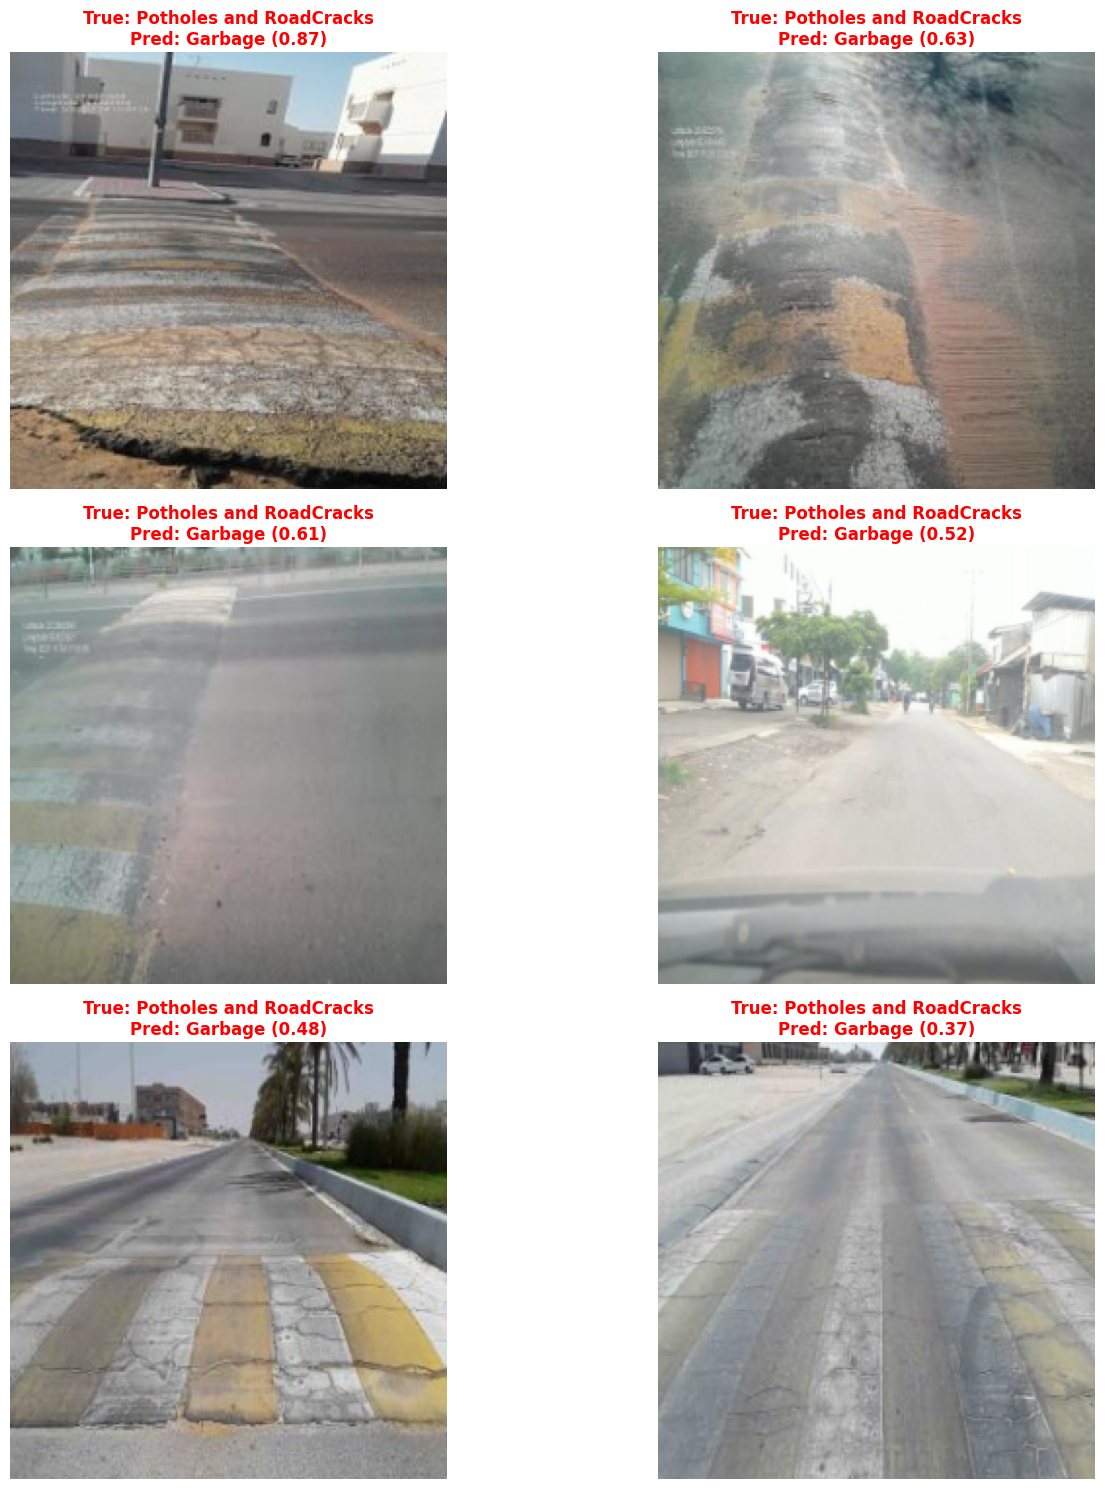

In [5]:
show_errors(filtered_errors, n=30)